In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
except ValueError:
    tpu = None
    print("Not connected to a TPU runtime")

if tpu:

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)


Running on TPU: 
Number of replicas: 8


In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [ ]:
# prompt: 구글마운트

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/news_summary_more.csv', nrows=100000)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98401


In [ ]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
# Print 15 random samples
data.sample(15)

,headlines,text
65056,Jacinda Ardern named next New Zealand PM,Jacinda Ardern has been named the next Prime M...
39717,Saudi bans produce imports from Kerala after N...,Saudi Arabia has temporarily banned processed ...
55894,Man City player suffers racist attack in Manch...,Greater Manchester Police has opened investiga...
67991,Which countries have the most number of millio...,"With 4.79 million millionaires, the United Sta..."
59397,NY woman shot dead by hunter who thought she w...,A 43-year-old woman walking her dogs in a New ...
40820,One candidate should contest from only one sea...,The Election Commission told the Supreme Court...
22583,Former Malaysian PM Razak to be charged for mo...,Former Malaysian Prime Minister Najib Razak wi...
62043,User freezes cryptocurrency worth $280 million...,An estimated $280 million worth of cryptocurre...
63836,First song 'Oye Firangi' from Kapil Sharma's '...,"'Oye Firangi', the first song from comedian Ka..."
30465,Meghan Markle to begin bridal procession alone...,"According to reports, Meghan Markle will walk ..."


# 데이터 전처리

# (1) 데이터 정리하기  
중복 샘플과 NULL 값이 존재하는 샘플 제거

In [ ]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [ ]:
# text 기준으로 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


In [ ]:
# 남은 null 값 확인
print(data.isnull().sum())



headlines    0
text         0
dtype: int64


In [ ]:
# 남은 null 값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


##### Text Normalization
텍스트 정규화를 위한 사전(dictionary)


In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


##### 불용어 제거

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 전처리 함수

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('=3')

=3


1. **소문자화**: 모든 문자를 소문자로 변환.
2. **HTML 태그 제거**: BeautifulSoup으로 제거.
3. **괄호 내용 제거**: 괄호로 닫힌 문자열 제거.
4. **쌍따옴표 제거**: 쌍따옴표 제거.
5. **약어 정규화**: 약어를 풀어쓰기.
6. **소유격 제거**: 소유격 제거.
7. **비영어 문자 제거**: 영어 외 문자를 공백으로 변환.
8. **문자 반복 줄이기**: 'm' 반복을 2개로 줄임.
9. **불용어 제거**: NLTK 불용어 리스트 사용.

### 전처리 결과 테스트






In [ ]:
temp_headlines = 'Man arrested for cheating Amazon of â¹30 lakh by taking refunds'
temp_text = "The Indian Space Research Organisation on Wednesday unveiled Human Space Flight Centre in Bengaluru for its â¹10,000-crore manned space mission 'Gaganyaan' scheduled for 2021. ISRO said the centre will be responsible for development of engineering systems for crew survival in space and crew selection and training. It'll also pursue activities for sustained human space flight missions, ISRO added."

print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.
print("text: ", preprocess_sentence(temp_text))

headlines: man arrested for cheating amazon of lakh by taking refunds
text:  indian space research organisation wednesday unveiled human space flight centre bengaluru crore manned space mission gaganyaan scheduled isro said centre responsible development engineering systems crew survival space crew selection training also pursue activities sustained human space flight missions isro added


### 전체 Text 컬럼 전처리

In [ ]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

# 각 Text 데이터에 대해 전처리 함수 적용
for text in data['text']:
    clean_text.append(preprocess_sentence(text))


In [ ]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for headlines in data['headlines']:
    clean_headlines.append(preprocess_sentence(headlines, remove_stopwords=False))


<ipython-input-16-f7bf49beb6b2>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거


In [ ]:
# 전처리 결과 확인
data.sample(5)

,headlines,text
98122,Jadeja does Dhoni-like no-look runout in Ranch...,Ravindra Jadeja dismissed Australian player Jo...
32914,India slip to no. 2 ODI ranking as England cl...,England displaced India to claim number one OD...
63645,"Deepika, I have amazing chemistry built on tru...","Actor Ranveer Singh, while talking about his r..."
35521,"Jio gets â¹3250cr Samurai loan, largest ever ...",Mukesh Ambani-led Reliance Jio Infocomm has ra...
95720,U'khand orders to shut down illegal meat shops...,Uttarakhand Chief Minister Trivendra Singh Raw...


In [ ]:
# 전처리 후 null값 확인
data.isnull().sum()

,0
headlines,0
text,0


In [ ]:
# null 값 제거
data.dropna(axis=0, inplace=True)

In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 전처리 전후 text 유사도 분석_TF-IDF 백터화 + 코사인유사도 계산

In [ ]:
original_texts = data['text'].sample(1000, random_state=42)  # 원본 텍스트
processed_texts = data['clean_text'].sample(1000, random_state=42) # 전처리 적용

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
original_tfidf = vectorizer.fit_transform(original_texts)
processed_tfidf = vectorizer.fit_transform(processed_texts)

# 코사인 유사도 계산
original_similarity = cosine_similarity(original_tfidf)
processed_similarity = cosine_similarity(processed_tfidf)

# 유사도 평균 비교
original_similarity_mean = np.mean(original_similarity)
processed_similarity_mean = np.mean(processed_similarity)

original_similarity_mean, processed_similarity_mean

KeyError: 'clean_text'

전처리 결과 데이터 프레임 저장

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


# (2) 데이터 분리

샘플의 최대 길이 정하기  

  
Headlines과 Text 의 최소, 최대, 평균

Headlines의 최소 길이 : 1
Headlines의 최대 길이 : 16
Headlines의 평균 길이 : 9.301108174054495
Text의 최소 길이 : 1
Text의 최대 길이 : 60
Text의 평균 길이 : 35.09968483123221


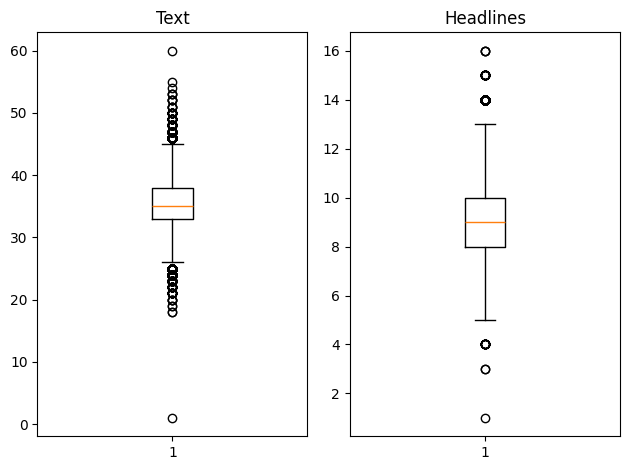

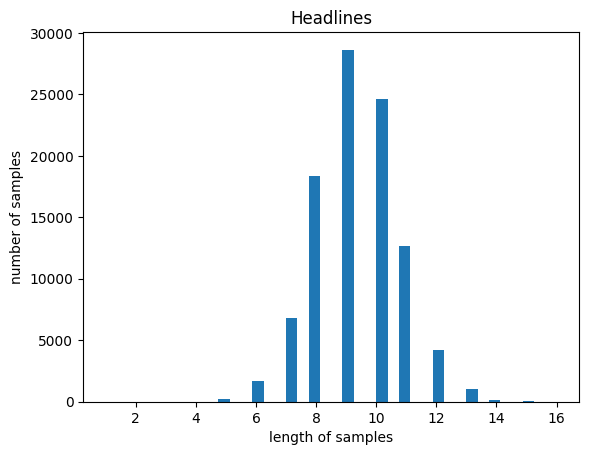

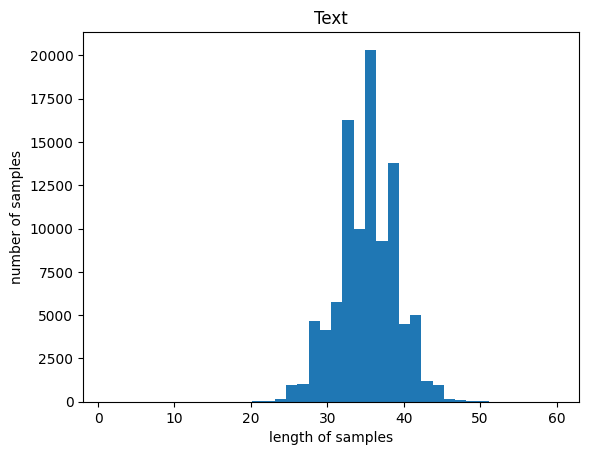

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('Headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('Headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('Headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('Text의 최소 길이 : {}'.format(np.min(text_len)))
print('Text의 최대 길이 : {}'.format(np.max(text_len)))
print('Text의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


##### 최대 길이 정하기
headlines_max_len = 12
text_max_len = 40

In [ ]:
headlines_max_len = 12
text_max_len = 40
print('=3')

=3


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [ ]:
below_threshold_len(headlines_max_len,  data['headlines'])
below_threshold_len(text_max_len, data['text'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9239049892968879


임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

In [ ]:
# Text와 Headlines 길이 조건으로 필터링
data = data[
    (data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len))&
    (data['text'].apply(lambda x: len(x.split()) <= text_max_len))
]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97168



### 시작 토큰과 종료 토큰 추가하기


In [ ]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-32-aee9c2be174e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-32-aee9c2be174e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


##### 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장






In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


테스트 데이터 분리

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19433


전체 데이터 분리






In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77735
훈련 레이블의 개수 : 77735
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


# (3) 정수 인코딩


### Vocabulary
encoder_input_train 단어 집합

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

AttributeError: 'int' object has no attribute 'lower'

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 0
등장 빈도가 6번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 0


ZeroDivisionError: division by zero

In [ ]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 18,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

AttributeError: 'int' object has no attribute 'lower'

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[127, 27, 988, 1638, 1078, 7852, 14724, 612, 9434, 526, 20, 1748, 1334, 236, 2058, 1361, 3, 13, 993, 587, 346, 11803, 5601, 3789, 31, 23, 104, 14724, 3096, 42, 831, 1221, 1780, 1195, 50, 1334, 1361], [97, 219, 4178, 5266, 6075, 5069, 1380, 5266, 1929, 760, 392, 14, 143, 14, 10681, 770, 1282, 3201, 2936, 401, 5540, 454, 4779, 1070, 589, 1, 2660, 5024, 335, 10933, 409, 154, 2081, 6, 264, 2401, 219], [166, 20, 338, 813, 159, 59, 8, 819, 4027, 79, 827, 781, 10934, 2699, 1126, 74, 781, 43, 241, 2699, 1126, 53, 5215, 2763, 3899, 17, 279, 114, 8, 83, 870, 3360, 20]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29988
등장 빈도가 5번 이하인 희귀 단어의 수: 19624
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10364
단어 집합에서 희귀 단어의 비율: 65.43950913698812
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.719691476202066


In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 968, 54, 1300, 1315, 1074, 1495, 6153], [1, 4231, 969, 131, 7, 3304, 1637, 56, 4488, 415, 3242], [1, 218, 11, 25, 38, 4, 1749, 853, 63, 67, 135, 205], [1, 4100, 107, 160, 9, 13, 167, 29, 41, 115], [1, 140, 19, 542, 91, 79, 2214, 3083, 6472]]
target
decoder  [[968, 54, 1300, 1315, 1074, 1495, 6153, 2], [4231, 969, 131, 7, 3304, 1637, 56, 4488, 415, 3242, 2], [218, 11, 25, 38, 4, 1749, 853, 63, 67, 135, 205, 2], [4100, 107, 160, 9, 13, 167, 29, 41, 115, 2], [140, 19, 542, 91, 79, 2214, 3083, 6472, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77735
훈련 레이블의 개수 : 77735
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433



## 패딩하기


In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


# (4) 모델 설계하기

### 인코더 설계

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)  # LSTM 2 layers, getting output, hidden state, and cell state
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  # Passing the output of LSTM 1 to LSTM 2

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)  # LSTM 3 layers, getting output, hidden state, and cell state
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)  # Passing the output of LSTM 2 to LSTM 3

### 디코더 설계

##### 디코더 입력층 설계

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일  
하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함



##### 디코더 출력층 설계

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      2,304,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 10000)    │      2,570,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,993,104 (30.49 MB)

 Trainable params: 7,993,104 (30.49 MB)

 Non-trainable params: 0 (0.00 B)

### 디코더 출력증 업데이트 with 어텐션 메커니즘  

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      2,304,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 10000)    │      5,130,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,553,360 (40.26 MB)

 Trainable params: 10,553,360 (40.26 MB)

 Non-trainable params: 0 (0.00 B)

# (5) 모델 훈련하기


In [ ]:
with strategy.scope():
    # 인코더 설계 시작
    embedding_dim = 128
    hidden_size = 256

    # 인코더
    encoder_inputs = Input(shape=(text_max_len,))
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    # 디코더 설계
    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # 어텐션 층
    attn_layer = AdditiveAttention(name='attention_layer')
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    # 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model.summary()

    # 모델 컴파일
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 128)        │      2,304,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 50, 256),      │        394,240 │ embedding_2[0][0]      │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm_4[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 128)      │      1,280,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 50, 256),      │        525,312 │ lstm_5[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_3[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_6[0][1],          │
│                           │ 256)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_7[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_7[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, None, 10000)    │      5,130,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,553,360 (40.26 MB)

 Trainable params: 10,553,360 (40.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=20
)

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - loss: 6.1435 - val_loss: 5.4015
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 5.3115 - val_loss: 5.0248
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.9870 - val_loss: 4.8260
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.7645 - val_loss: 4.6441
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.5463 - val_loss: 4.4776
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.3873 - val_loss: 4.3585
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 4.2398 - val_loss: 4.2609
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.1052 - val_loss: 4.1844
Epoch 9/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 4.0177 - val_loss: 4.1186
Epoch 10/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 3.8849 - val_loss: 4.0602
Epoch 11/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 3.7989 - val_loss: 4.0108
Epoch 12/20
304/304 ━━━━━━━━━━

### 학습 결과 시각화






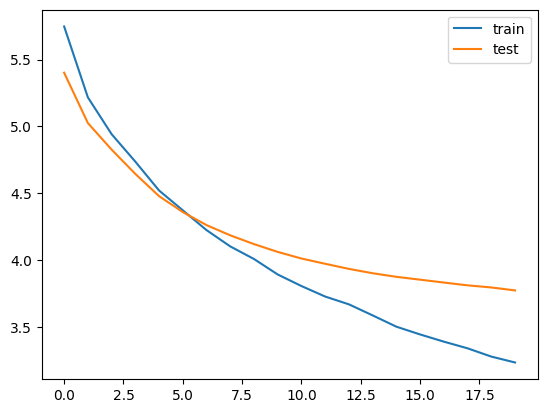

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# (6) 인퍼런스 모델 구현하기


테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # text 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # headlines 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # headlines 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


정답 문장이 없는 추론(inference) 단계에서 모델 설계를 별도로 해주는 이유:  
생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문





# (7) 인퍼런스 모델 테스트


테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0) and (i != tar_word_to_index['sostoken']) and (i != tar_word_to_index['eostoken'])):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.






In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# (8) 추출적 요약


In [ ]:
! pip install summa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=ab8be799ef50dc35f0bb03ff8fa71156931467427fa210cf2ab484c258ab60ff
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [ ]:
from summa.summarizer import summarize

 data 라는 DataFrame에서 "text" 열을 하나의 문자열로 합친 후, summa 라이브러리로 요약

In [ ]:
sample_text = " ".join(data["text"].sample(5).tolist())

In [ ]:
summary_result = summarize(sample_text, words=30)
print(summary_result)

# 회고


- 배운 점:  
이번 프로젝트를 하면서 전처리하는 과정의 중요성을 이미지 데이터보다 크게 느끼는 부분이 많았다. 텍스트 정규화, 불용어 제거, 중복된 기사 제거, 시작/종료 토큰 추가 같은 작업을 코드로 구현하면서 자연어에서 데이터 품질이 모델 성능에 미치는 영향을 확인할 수 있었다. 개인적으로 실험해보고 접근해 본 점은 전처리 과정의 속도를 양상시키는 코드 구성 측면에서 4가지 방법론을 배웠고 멀티프로세싱을 시도해보았다. 그리고 전처리 전후과정에서 달라지는 샘플 유사도 분석method를 실험해보았다. (TF-IDF 백터화, 코사인유사도 계산 등).
트랜스포머 아키텍쳐 이전의 모델들의 변천사를 케창딥 때보다 좀더 실무적으로 리뷰할 수 있었던 것에 만족한다. 아직 추상적 요약을 네이버 등 사용하고 있는 것으로 보아 추상과 추출에 대한 비교 이해는 아직은 중요해 보이고 추출에 대한 성능실험을 서비스프로젝트로 이어갈 수 있다면 유의미한 활동이지 않을까 싶다.

- 아쉬운 점 :   
하이퍼파라미터 튜닝과 다양한 실험을 충분히 하지 못한 것이 조금 아쉽다. 전처리 전후로 데이터 백업에 대한 워크플로우를 아직 메뉴얼링이 되있지 않아 토크나이징과 전처러 과정의 중복 시행 발생 등은 앞으로 개선이 필요해 보인다.
   
- 느낀 점 :  
실제 뉴스 데이터를 다루며 전처리부터 모델 설계, 학습, 예측까지 전체 파이프라인을 구축하는 과정은 도전적이었지만 그만큼 보람도 컸다. 코드 디버깅과 오류를 해결하면서 문제를 해결하는 능력이 확실히 늘어났고, 데이터의 특성과 모델 구조에 대해 깊이 고민하는 시간이 많았다. 추출적 요약과 추상적 요약을 비교하면서 자연어 처리의 다양한 가능성을 체감한 점도 의미 있는 경험이었다.  
   
- 어려웠던 점 :  
 데이터 전처리는 리소스와 운영과정에서의 애로사항이 있었고 인퍼런스 아키덱쳐까지 전반에 걸쳐 디버깅 과정 발생시 프로젝트가 리셋될 수 있는 상황이 다소 절망스러울 때가 있었다. 케창딥에서도 RNN과 transformer 학습과정이 다소 컴팩트했는데 exploration의 프로젝트를 그 학습기간에 연결해 이어가는 커리큘럼도 나름 괜찮을 것 같습니다.